### Thinking1
今天讲解了时间序列预测的两种方式，实际上在数据库内建时间属性后，可以产生时序数据库，请思考什么是时序数据库？为什么时间序列数据成为增长最快的数据类型之一

### Thinking2
BCG Matrix（波士顿矩阵）四象限分别代表什么？不同象限，有怎样的数据决策

### Action1
股票价格预测
任何股票价格预测，比如 美吉姆
http://quotes.money.163.com/trade/lsjysj_002621.html
历史数据（从1990年12月19日至今）
请你编写代码对该股票未来3个月的变化进行预测（可以按照月来统计，也可以按照天）
模型选择：ARMA/ARIMA/LSTM 中的任意一种

In [2]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# 载入数据（2015-7-31至2020-10-16）
df = pd.read_csv('./000983.csv',encoding = 'gb2312')
print(df.shape)
df.head()

(1271, 15)


,日期,股票代码,名称,收盘价,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,换手率,成交量,成交金额,总市值,流通市值
0,2020-10-16,'000983,西山煤电,5.45,5.50,4.96,5.00,5.00,0.45,9.0000,6.4909,265903786,1.423987e+09,2.232625e+10,2.232625e+10
1,2020-10-15,'000983,西山煤电,5.00,5.15,4.65,4.71,4.68,0.32,6.8376,3.8908,159386998,7.899007e+08,2.048280e+10,2.048280e+10
2,2020-10-14,'000983,西山煤电,4.68,4.76,4.64,4.74,4.75,-0.07,-1.4737,0.9558,39154059,1.832627e+08,1.917190e+10,1.917190e+10
3,2020-10-13,'000983,西山煤电,4.75,4.79,4.68,4.77,4.71,0.04,0.8493,1.4057,57584514,2.728512e+08,1.945866e+10,1.945866e+10
4,2020-10-12,'000983,西山煤电,4.71,4.77,4.63,4.64,4.63,0.08,1.7279,2.0882,85546040,4.024621e+08,1.929480e+10,1.929480e+10


#### ARMA, ARIMA

In [2]:
import statsmodels.api as sm

# 取收盘价作为当日价格，截取数据
data = df[['日期','收盘价']]
data.rename(columns={'日期':'timestamp', '收盘价':'price'}, inplace=True)
data.timestamp = pd.to_datetime(data.timestamp)
data.price = data.price.apply(pd.to_numeric)
data = data.set_index('timestamp')
data.sort_index(inplace=True)
print(data.head())

# 按月、季度、年
# data_m = data.resample('M').mean()
# data_q = data.resample('Q-DEC').mean()
# data_y = data.resample('A-DEC').mean()

            price
timestamp        
2015-07-27   6.50
2015-07-28   6.37
2015-07-29   6.67
2015-07-30   6.37
2015-07-31   6.43


In [3]:
# 查看是否有缺失值
data.isnull().sum(axis=0)
# 如有，可按线性插值补全
# data.price.interpolate(inplace=True)

price    0
dtype: int64

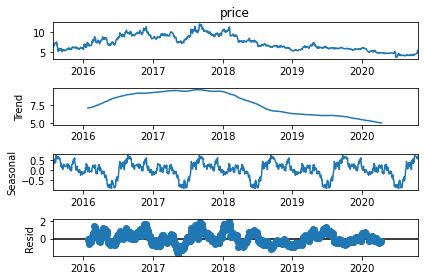

In [4]:
# 查看趋势与周期性
import matplotlib.pyplot as plt

result = sm.tsa.seasonal_decompose(data.price, period=250) # 一年大约有250个交易日
result.plot()
plt.show()

In [5]:
# 平稳性检验
t=sm.tsa.stattools.adfuller(data)
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = t[0]
output['value']['p-value'] = t[1]
output['value']['Lags Used'] = t[2]
output['value']['Number of Observations Used'] = t[3]
output['value']['Critical Value(1%)'] = t[4]['1%']
output['value']['Critical Value(5%)'] = t[4]['5%']
output['value']['Critical Value(10%)'] = t[4]['10%']
print(output)

                                value
Test Statistic Value         -1.47717
p-value                      0.544775
Lags Used                           8
Number of Observations Used      1262
Critical Value(1%)           -3.43554
Critical Value(5%)           -2.86383
Critical Value(10%)          -2.56799


In [6]:
# 由于t值均大于不同程度拒绝原假设的统计值，原序列并非平稳，进一步检验一次差分
diff1 = data.diff(1).dropna()
t=sm.tsa.stattools.adfuller(diff1)
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = t[0]
output['value']['p-value'] = t[1]
output['value']['Lags Used'] = t[2]
output['value']['Number of Observations Used'] = t[3]
output['value']['Critical Value(1%)'] = t[4]['1%']
output['value']['Critical Value(5%)'] = t[4]['5%']
output['value']['Critical Value(10%)'] = t[4]['10%']
print(output)

                                   value
Test Statistic Value            -17.5877
p-value                      3.97804e-30
Lags Used                              4
Number of Observations Used         1265
Critical Value(1%)              -3.43553
Critical Value(5%)              -2.86383
Critical Value(10%)             -2.56799


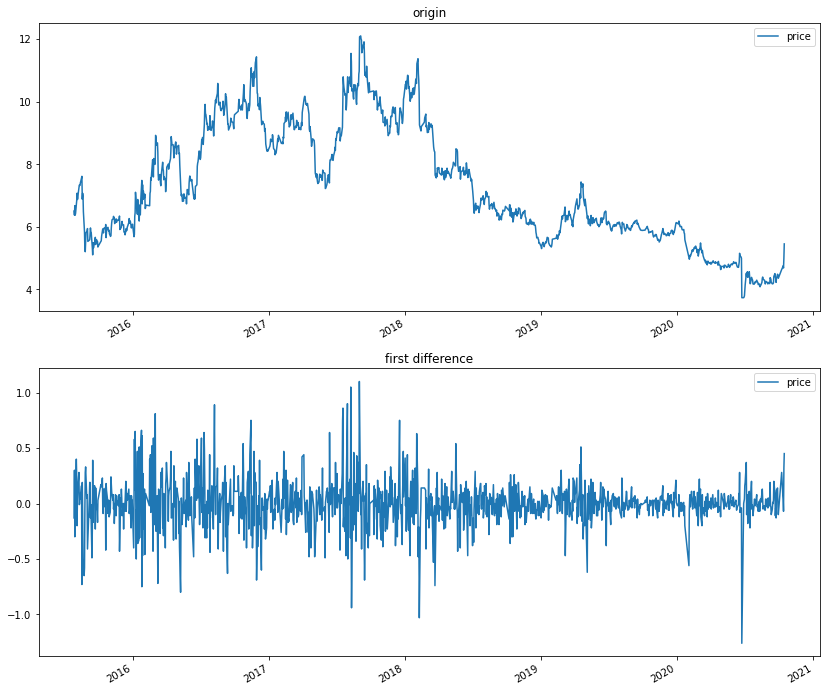

In [7]:
# 由于t值均小于不同程度拒绝原假设的统计值，同时p值也接近于0，一次差分平稳，可视化如下
fig = plt.figure(figsize=(14,20))
# 原始数据
ax1 = plt.subplot(311)
data.plot(ax=ax1)
plt.xlabel(None)
plt.title('origin')

# 一次差分
ax2 = plt.subplot(312)
diff1.plot(ax=ax2)
plt.xlabel(None)
plt.title('first difference')

# # 二次差分
# ax3 = plt.subplot(313)
# diff2 = diff1.diff(1) #diff(2)不是二次差分，只是间隔一项相减
# diff2.plot(ax=ax3)
# plt.title('second difference')
plt.show()

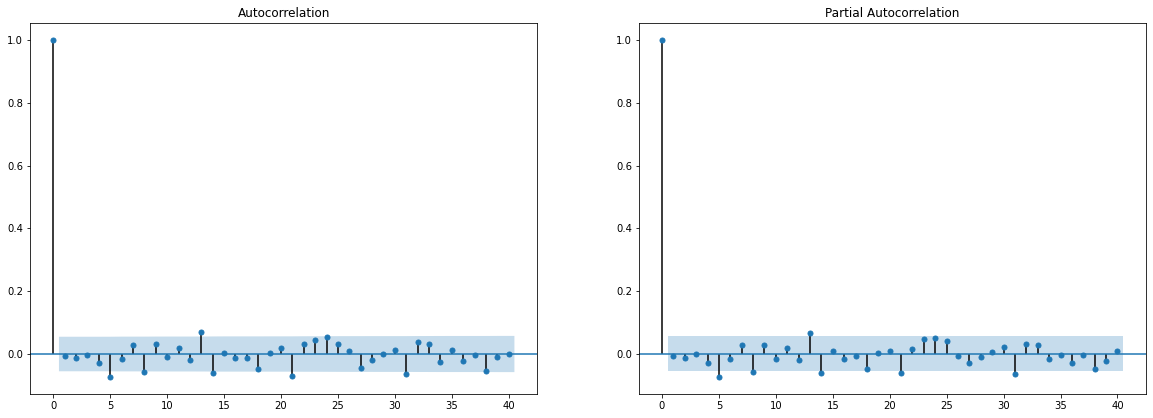

In [8]:
# 确定p,q值
fig = plt.figure(figsize=(20,15))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
fig = sm.graphics.tsa.plot_acf(diff1,lags=40,ax=ax1)
fig = sm.graphics.tsa.plot_pacf(diff1,lags=40,ax=ax2)

In [11]:
# 由于ACF,PACF均为1阶截尾，PACF1阶截尾，故可取 q=1, q=1
# 最终选择模型ARIMA(1,1,1)
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')
arima = ARIMA(data.price, order=(1,1,1)).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 1271
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 206.349
Date:                Sun, 18 Oct 2020   AIC                           -406.698
Time:                        17:09:06   BIC                           -391.258
Sample:                             0   HQIC                          -400.898
                               - 1271                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9563      0.033     29.361      0.000       0.892       1.020
ma.L1         -0.9732      0.026    -36.865      0.000      -1.025      -0.921
sigma2         0.0423      0.001     47.443      0.0

In [10]:
# 暴力穷举ARMA进行对照
from itertools import product

# 设置参数范围
ps = range(0, 5)
qs = range(0, 5)
parameters = product(ps, qs)
parameters_list = list(parameters)

# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARIMA(data.price,order=(param[0], 0, param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())
# 各项指标不如ARIMA好,与平稳性检验结果相合

最优模型:                                 SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 1271
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 208.512
Date:                Sun, 18 Oct 2020   AIC                           -403.025
Time:                        17:08:41   BIC                           -366.992
Sample:                             0   HQIC                          -389.490
                               - 1271                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0149      2.222      2.707      0.007       1.660      10.370
ar.L1          0.2923      0.055      5.351      0.000       0.185       0.399
ar.L2         -0.2158      0.065     -3.320  

In [12]:
import calendar
from datetime import timedelta

# 对未来n天进行预测
n = 90
# 获取未来n天中的交易日（周一至周五）
data2 = data[['price']]
last_day = pd.to_datetime(data2.index[len(data2)-1])
# print(last_day)
# last_day.weekday()
date_list = []
for i in range(90):
    last_day += timedelta(days=1)
    if last_day.weekday() in range(5):
        date_list.append(last_day)

In [13]:
# 预测
future = pd.DataFrame(index=date_list, columns=data.columns)
data2 = pd.concat([data2, future])
print(arima.predict(0,data.shape[0]-1)) # 差分损失第一项
print(best_model.predict())

timestamp
2015-07-27    0.000000
2015-07-28    6.500000
2015-07-29    6.371781
2015-07-30    6.667563
2015-07-31    6.371852
                ...   
2020-10-12    4.625630
2020-10-13    4.704390
2020-10-14    4.743862
2020-10-15    4.675213
2020-10-16    4.989912
Name: predicted_mean, Length: 1271, dtype: float64
timestamp
2015-07-27    6.014909
2015-07-28    6.498146
2015-07-29    6.370346
2015-07-30    6.667382
2015-07-31    6.359615
                ...   
2020-10-12    4.634895
2020-10-13    4.699427
2020-10-14    4.762643
2020-10-15    4.692619
2020-10-16    4.990291
Name: predicted_mean, Length: 1271, dtype: float64


In [14]:
data2['forecast_arima'] = arima.predict(0, data.shape[0]-1+len(date_list)).values
data2['forecast_arma'] = best_model.predict(0, data.shape[0]-1+len(date_list)).values
data2.drop(index=data2.index[0], inplace=True)

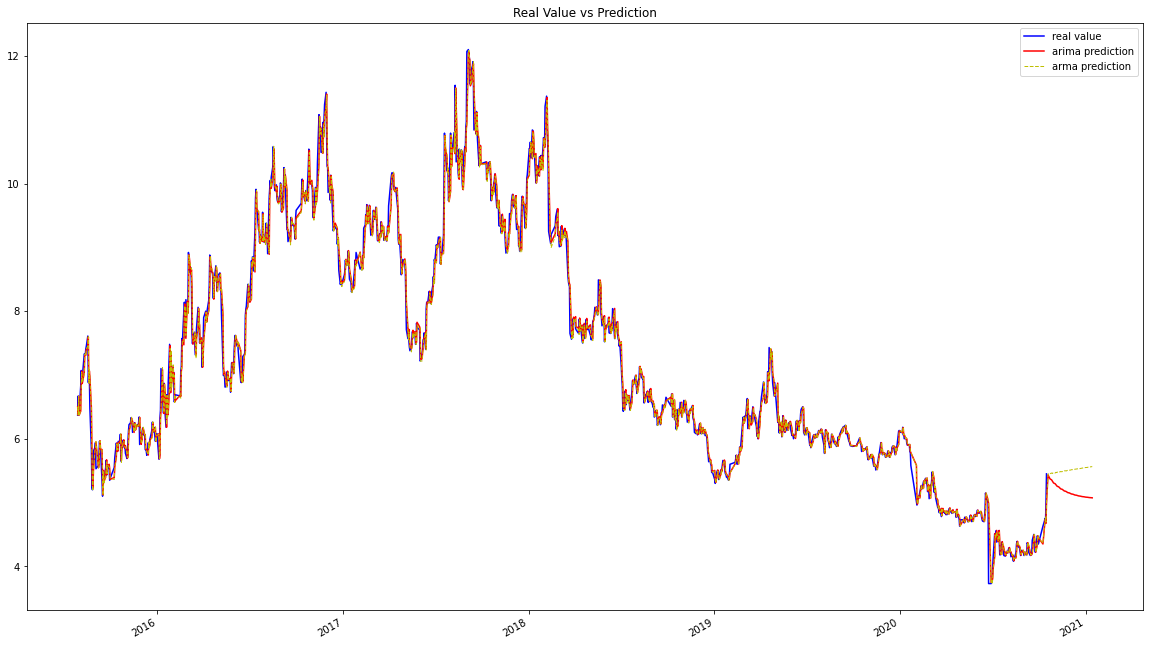

In [16]:
# 可视化
fig = plt.figure(figsize=(20,12))
data2.price.plot(c='b')
data2.forecast_arima.plot(c='r')
data2.forecast_arma.plot(c='y', linewidth=1, linestyle='--')
plt.legend(['real value', 'arima prediction', 'arma prediction'])
plt.title('Real Value vs Prediction')
plt.show()

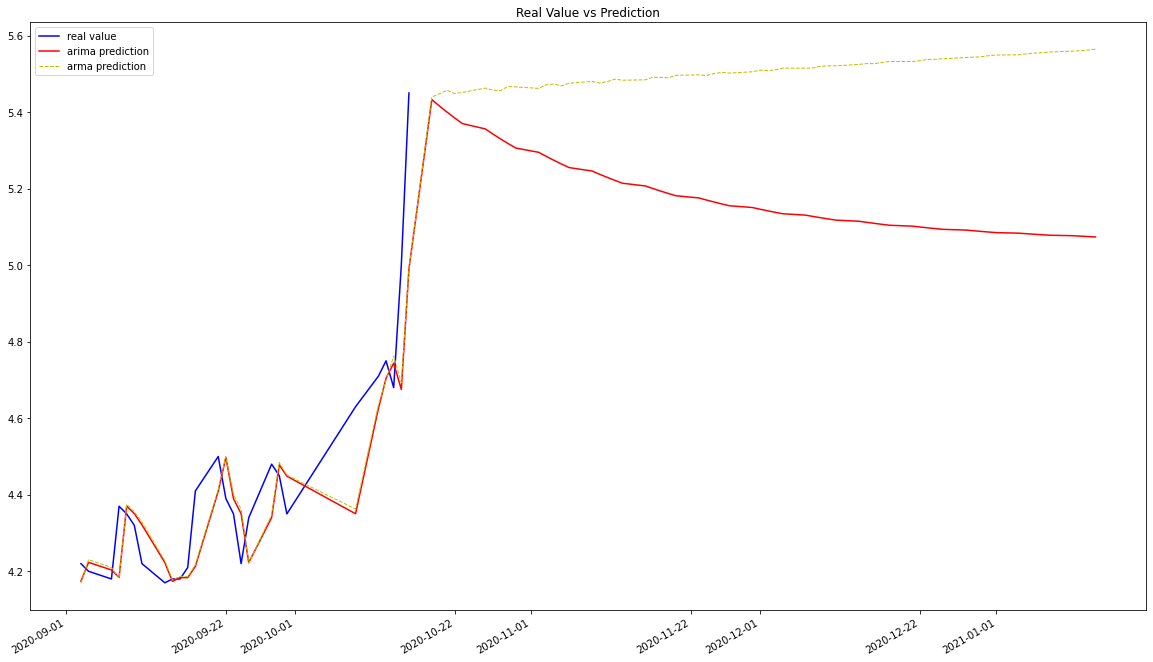

In [17]:
# 放大局部
temp = data2.tail(90)
fig = plt.figure(figsize=(20,12))
temp.price.plot(c='b')
temp.forecast_arima.plot(c='r')
temp.forecast_arma.plot(c='y', linewidth=1, linestyle='--')
plt.legend(['real value', 'arima prediction', 'arma prediction'])
plt.title('Real Value vs Prediction')
plt.show()